# Import Libraries

In [ ]:
!pip install lazypredict --upgrade lazypredict

In [ ]:
!pip install gensim

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install pymc3
!pip install arviz

In [ ]:
!pip install xgboost

In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import arviz as az
from sklearn.metrics import accuracy_score
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.mixture import GaussianMixture
import gensim
import gensim.corpora as corpora
# import pymc3 as pm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Import Data

In [2]:
cluster_df = pd.read_csv('cluster_sample.csv')
cluster_df.head()

,index,kmer_seq,project_id,run_accession,sample_accession,center_name,instrument_platform,instrument_model,host,Topic 0,Topic 1,Topic 2,Topic 3,optimal
0,1291554,TTTTTATTTTTATATGCTGAGCCAG,PRJEB35615,ERR3698084,SAMEA6262668,"Department of Ophthalmology, Inselspital",ILLUMINA,Illumina HiSeq 3000,NaN,0.25,0.25,0.25,0.25,-1
1,505306,GCGGTGGCTCACGCCTGTAATCCCA,PRJEB35615,ERR3698057,SAMEA6262641,"Department of Ophthalmology, Inselspital",ILLUMINA,Illumina HiSeq 3000,NaN,0.60,0.13,0.14,0.13,0
2,1580819,TTGCTCTTGTCGCCCCGGCTGGAGT,PRJEB35615,ERR3698091,SAMEA6262675,"Department of Ophthalmology, Inselspital",ILLUMINA,Illumina HiSeq 3000,NaN,0.25,0.25,0.25,0.25,-1
3,1771663,CTTTCAAAATCATCAGCAATAATAA,PRJEB35615,ERR3698096,SAMEA6262680,"Department of Ophthalmology, Inselspital",ILLUMINA,Illumina HiSeq 3000,NaN,0.25,0.25,0.25,0.25,-1
4,945757,GGAGAATCGCTTGAACCTGGGAGGT,PRJEB35615,ERR3698079,SAMEA6262663,"Department of Ophthalmology, Inselspital",ILLUMINA,Illumina HiSeq 3000,NaN,0.25,0.25,0.25,0.25,-1


In [3]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76384 entries, 0 to 76383
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                76384 non-null  int64  
 1   kmer_seq             76384 non-null  object 
 2   project_id           76384 non-null  object 
 3   run_accession        76384 non-null  object 
 4   sample_accession     76384 non-null  object 
 5   center_name          76384 non-null  object 
 6   instrument_platform  76384 non-null  object 
 7   instrument_model     76384 non-null  object 
 8   host                 19096 non-null  object 
 9   Topic 0              76384 non-null  float64
 10  Topic 1              76384 non-null  float64
 11  Topic 2              76384 non-null  float64
 12  Topic 3              76384 non-null  float64
 13  optimal              76384 non-null  int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 8.2+ MB


# Data Preparation

In [4]:
# A little feature engineering
cluster_df['sequence_freq_a']  = cluster_df['kmer_seq'].str.count('A')/cluster_df['kmer_seq'].str.len()
cluster_df['sequence_freq_c']  = cluster_df['kmer_seq'].str.count('C')/cluster_df['kmer_seq'].str.len()
cluster_df['sequence_freq_g']  = cluster_df['kmer_seq'].str.count('G')/cluster_df['kmer_seq'].str.len()
cluster_df['sequence_freq_t']  = cluster_df['kmer_seq'].str.count('T')/cluster_df['kmer_seq'].str.len()

In [5]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(cluster_df.loc[:, cluster_df.columns.str.match('^Topic|^sequence')], 
                                                    cluster_df['center_name'], 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [6]:
X_train.head()

,Topic 0,Topic 1,Topic 2,Topic 3,sequence_freq_a,sequence_freq_c,sequence_freq_g,sequence_freq_t
34168,0.14,0.14,0.13,0.59,0.40,0.36,0.08,0.16
25116,0.59,0.14,0.13,0.13,0.40,0.40,0.08,0.12
40552,0.25,0.25,0.25,0.25,0.28,0.08,0.20,0.44
70410,0.14,0.14,0.58,0.14,0.28,0.00,0.32,0.40
72678,0.25,0.25,0.25,0.25,0.00,0.44,0.04,0.52


In [7]:
# Standardize
scaler = StandardScaler(with_mean= False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Lazy Classifier

In [ ]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

# Mixed Gaussian

In [8]:
model = GaussianMixture(n_components=5, tol=0.1, covariance_type = 'full', random_state = 42, n_init=3)
model.fit(X_train)
yhat = pd.Series(model.predict(X_test))
pd.concat([yhat.reset_index(drop = True),y_test.reset_index(drop = True)],axis = 1, ignore_index = True).groupby([0])[1].value_counts()

0  1                                       
0  Weill Cornell Medical College in Qatar       645
   GEO                                          345
   Department of Ophthalmology, Inselspital      64
   SUB9454898                                    21
1  GEO                                          374
   Weill Cornell Medical College in Qatar       277
   Department of Ophthalmology, Inselspital     193
   SUB9454898                                    87
2  Department of Ophthalmology, Inselspital    3515
   SUB9454898                                  2891
   Weill Cornell Medical College in Qatar      2330
   GEO                                         1692
3  GEO                                         1248
   Weill Cornell Medical College in Qatar       469
   SUB9454898                                    26
   Department of Ophthalmology, Inselspital       2
4  SUB9454898                                   790
   GEO                                          154
   Weill Cornell Med

In [9]:
yhat

0        3
1        2
2        2
3        2
4        0
        ..
15272    2
15273    2
15274    2
15275    2
15276    2
Length: 15277, dtype: int64

# KMER's Of Interest

In [10]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [11]:
model = XGBClassifier()
model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
model.fit(X_train, y_train)
print(model)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [16]:
model.best_params_

{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

In [ ]:
#Attempt 2
params = {
 "learning_rate" : [0.20,0.225,0.25,0.275,0.30,0.35],
 "max_depth" : [12,13,14, 15],
 "min_child_weight" : [ 2, 3,4, 5 ],
 "gamma": [ 0.35, 0.4, 0.45,0.5 ],
 "colsample_bytree" : [ 0.2,0.25,0.3, 0.35 ]
}
model = XGBClassifier()
model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
model.fit(X_train, y_train)
print(model)

In [18]:
type(model.best_estimator_)

xgboost.sklearn.XGBClassifier

In [ ]:
model = XGBClassifier(learning_rate = 0.25,max_depth = 12, min_child_weight = 5, gamma= 0.5, colsample_bytree = 0.2)
model.fit(X_train, y_train)

In [19]:
y_pred = model.predict_proba(X_test)
predictions = pd.DataFrame(y_pred)
predictions.columns = list(model.classes_)
predictions

,"Department of Ophthalmology, Inselspital",GEO,SUB9454898,Weill Cornell Medical College in Qatar
0,0.01,0.71,0.01,0.27
1,0.33,0.19,0.25,0.23
2,0.43,0.09,0.24,0.25
3,0.29,0.20,0.27,0.23
4,0.02,0.38,0.02,0.59
...,...,...,...,...
15272,0.29,0.17,0.26,0.28
15273,0.54,0.16,0.07,0.22
15274,0.30,0.20,0.27,0.23
15275,0.36,0.17,0.27,0.21


In [20]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.78%


In [21]:
predictions['predict_label'] = y_pred
predictions['actual_label'] = np.array(y_test)
predictions

,"Department of Ophthalmology, Inselspital",GEO,SUB9454898,Weill Cornell Medical College in Qatar,predict_label,actual_label
0,0.01,0.71,0.01,0.27,GEO,GEO
1,0.33,0.19,0.25,0.23,"Department of Ophthalmology, Inselspital",GEO
2,0.43,0.09,0.24,0.25,"Department of Ophthalmology, Inselspital",GEO
3,0.29,0.20,0.27,0.23,"Department of Ophthalmology, Inselspital",SUB9454898
4,0.02,0.38,0.02,0.59,Weill Cornell Medical College in Qatar,GEO
...,...,...,...,...,...,...
15272,0.29,0.17,0.26,0.28,"Department of Ophthalmology, Inselspital",SUB9454898
15273,0.54,0.16,0.07,0.22,"Department of Ophthalmology, Inselspital","Department of Ophthalmology, Inselspital"
15274,0.30,0.20,0.27,0.23,"Department of Ophthalmology, Inselspital",Weill Cornell Medical College in Qatar
15275,0.36,0.17,0.27,0.21,"Department of Ophthalmology, Inselspital",SUB9454898


In [22]:
predictions['correct_flag'] = np.where(predictions['predict_label'] == predictions['actual_label'],True,False)
predictions['max_value'] = predictions.iloc[:,0:3].max(axis=1)

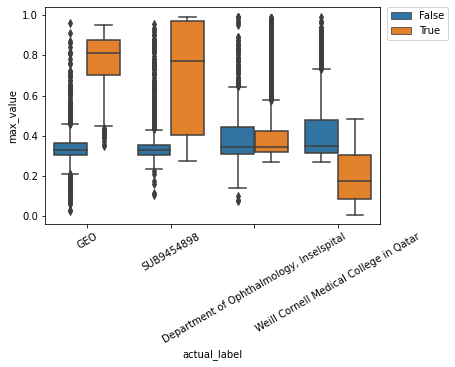

In [23]:
ax = sns.boxplot(x="actual_label", y="max_value", hue="correct_flag",
                 data=predictions)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Remove Even Probabilities

## Data Preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cluster_df.loc[cluster_df['optimal'] != -1 , cluster_df.columns.str.match('^Topic|^sequence')], 
                                                    cluster_df.loc[cluster_df['optimal'] != -1,'center_name'], 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [ ]:
# Standardize
scaler = StandardScaler(with_mean= False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Lazy Classifier

In [ ]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

## Mixed Gaussian

In [ ]:
model = GaussianMixture(n_components=5, tol=0.1, covariance_type = 'full', random_state = 42, n_init=3)
model.fit(X_train)
yhat = pd.Series(model.predict(X_test))
pd.concat([yhat.reset_index(drop = True),y_test.reset_index(drop = True)],axis = 1, ignore_index = True).groupby([0])[1].value_counts()

In [ ]:
yhat = pd.Series(model.predict(X_train))
pd.concat([yhat.reset_index(drop = True),y_train.reset_index(drop = True)],axis = 1, ignore_index = True).groupby([0])[1].value_counts()

## KMER's Of Interest

In [ ]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
model = XGBClassifier()
model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
model.fit(X_train, y_train)
print(model)

In [ ]:
model.best_estimator_

In [ ]:
#Attempt 2
params = {
 "learning_rate" : [0.05,0.075,0.1,0.125,0.15],
 "max_depth" : [13,15,17,19,21],
 "min_child_weight" : [1,2,3],
 "gamma": [ 0.25,0.3,0.35,0.4 ],
 "colsample_bytree" : [0.6,0.65,0.7,0.75,0.8 ]
}
model = XGBClassifier()
model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
model.fit(X_train, y_train)
print(model)

In [ ]:
model.best_estimator_

In [ ]:
model = XGBClassifier(learning_rate = 0.05,max_depth = 17, min_child_weight = 2, gamma= 0.4, colsample_bytree = 0.65)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict_proba(X_test)
predictions = pd.DataFrame(y_pred)
predictions.columns = list(model.classes_)
predictions

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
predictions['predict_label'] = y_pred
predictions['actual_label'] = np.array(y_test)
predictions

In [ ]:
predictions['correct_flag'] = np.where(predictions['predict_label'] == predictions['actual_label'],True,False)
predictions['max_value'] = predictions.iloc[:,0:3].max(axis=1)

In [ ]:
ax = sns.boxplot(x="actual_label", y="max_value", hue="correct_flag",
                 data=predictions)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Create Function

In [44]:
def classification_model(data, test_pct = 0.2,optimal = True, seed = 42, dep_var = 'center_name', learning_rate = [0.05,0.10,0.15,0.20,0.25,0.30],
                        max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15], min_child_weight = [ 1, 3, 5, 7 ],
                        gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ], colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ]):
    # A little additional feature engineering
    data['sequence_freq_a']  = data['kmer_seq'].str.count('A')/data['kmer_seq'].str.len()
    data['sequence_freq_c']  = data['kmer_seq'].str.count('C')/data['kmer_seq'].str.len()
    data['sequence_freq_g']  = data['kmer_seq'].str.count('G')/data['kmer_seq'].str.len()
    data['sequence_freq_t']  = data['kmer_seq'].str.count('T')/data['kmer_seq'].str.len()
    
    print('Of the ' + str(data.shape[0]) + ' KMERs in our dataset, ' + str(data.loc[data['optimal'] == -1,:].shape[0]) + ' have an equal probability across topics -- meaning they are universal contaminants. If you left optimal = True then these KMERs are dropped from classification.')
    # Split data
    if optimal == True:
        data = data.loc[data['optimal'] != -1,:]
    else:
        pass
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns.str.match('^Topic|^sequence')], 
                                                    data[dep_var], 
                                                    test_size = test_pct, 
                                                    random_state=seed)
    
    # Standardize
    scaler = StandardScaler(with_mean= False)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Model Set Up - First Pass
    params = {
     "learning_rate" : learning_rate,
     "max_depth" : max_depth,
     "min_child_weight" : min_child_weight,
     "gamma": gamma,
     "colsample_bytree" : colsample_bytree
    }
    
    model = XGBClassifier()
    model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
    model.fit(X_train, y_train)
    
    # Model Set Up - Second Pass
    if model.best_params_['min_child_weight'] <= 2:
        min_child_weight = np.arange(1, 3)
    else:
        min_child_weight = np.arange(model.best_params_['min_child_weight'] - 1, model.best_params_['min_child_weight'] + 1)
        
    if model.best_params_['max_depth'] <= 3:
        max_depth = np.arange(1, 5)
    else:
        max_depth = np.arange(model.best_params_['max_depth'] - 2, model.best_params_['max_depth'] + 2) 
        
    learning_rate = np.arange(model.best_params_['learning_rate'] - .05, model.best_params_['learning_rate'] + .05,step = 0.05) 
    gamma = np.arange(model.best_params_['gamma'] - .15, model.best_params_['gamma'] + .15, step = 0.1) 
    colsample_bytree = np.arange(model.best_params_['colsample_bytree'] - 0.05, model.best_params_['colsample_bytree'] + 0.05, step = 0.05) 

    params = {
     "learning_rate" : learning_rate,
     "max_depth" : max_depth,
     "min_child_weight" : min_child_weight,
     "gamma": gamma,
     "colsample_bytree" : colsample_bytree
    }
    
    model = XGBClassifier()
    model= RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
    model.fit(X_train, y_train)
    model = model.best_estimator_
    
    #Predictions
    y_pred = model.predict_proba(X_test)
    predictions = pd.DataFrame(y_pred)
    predictions.columns = list(model.classes_)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("The classification accuracy (on unseen data) for " + dep_var + " is %.2f%%" % (accuracy * 100.0))
    predictions['predict_label'] = y_pred
    predictions['actual_label'] = np.array(y_test)
    predictions['correct_flag'] = np.where(predictions['predict_label'] == predictions['actual_label'],True,False)
    predictions['max_value'] = predictions.iloc[:,0:3].max(axis=1)
    
    #Box Plot
    plt.figure()
    plt.subplot(1, 2, 1)
    box = sns.boxplot(x="actual_label", y="max_value", hue="correct_flag",
                 data=predictions).set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #Confusion Matrix
    plt.subplot(1, 2, 1)
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    cf_matrix.set_title('Confusion Matrix')
    cf_matrix.set_xlabel('\nPredicted Values')
    cf_matrix.set_ylabel('Actual Values')
#     cf_matrix.xaxis.set_ticklabels(['False','True'])
#     cf_matrix.yaxis.set_ticklabels(['False','True'])
    plt.show()
    #Create Object List
    object_list = [model,predictions,box,cf_matrix]
    return object_list

# Test Function

Of the 76384 KMERs in our dataset, 53400 have an equal probability across topics -- meaning they are universal contaminants. If you left optimal = True then these KMERs are dropped from classification.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.8s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.7s finished


The classification accuracy (on unseen data) for center_name is 78.42%


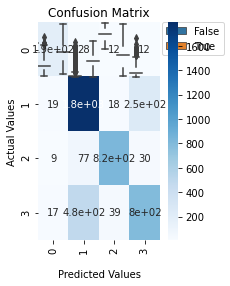

In [45]:
temp = classification_model(data = cluster_df)

In [48]:
temp[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55,
              gamma=0.05000000000000002, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)